# Primer Parcial SIS420
## Universitario: José Luis Flores Tito

El siguiente es un entrenamiento basado en el dataset: Calidad del Clima en Italia, ubicado en la siguiente direccion:
https://archive.ics.uci.edu/dataset/360/air+quality

este dataset cuenta con mas de 9000 datos de mediciones quimicas del clima en horas, para el examen se convertiran esas horas a dias y se armara una red neuronal con 7 datos de entrada, 128 neuronas y 30 datos de salida, todo esto porque el examen exige predecir el valor de los 30 dias siguientes para la validacion y nos basaremos en los 7 dias anteriores para predecir los 30 siguientes de manera iterativa.

In [4]:
# Importamos las funciones necesarias:
import matplotlib.pyplot as plt # Graficos
import numpy as np # para vectores
import pandas as pd # para manipular los datos
import torch # entrenamiento
import torch.nn as nn # para modelos neuronales

In [6]:
# Si GPU esta disponible se usa, sino CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Cargar el Dataset:
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',')

In [9]:
# Convertir columnas a numéros
features = ['CO(GT)','PT08.S1(CO)','NMHC(GT)','C6H6(GT)','PT08.S2(NMHC)',
            'NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)',
            'RH','AH']  # todas menos T ya que T sera nuestro objetivo a predecir
target = 'T'

for col in features + [target]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

## Convertir horas a dias:

In [10]:
# Agrupar por día y tomar promedio porque el dataset venia en horas
daily = df.groupby('Date')[features + [target]].mean().dropna().reset_index()

print(daily.head())
print("Número de días:", len(daily))

         Date    CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)  \
0  01/01/2005 -6.287500  1114.250000  -200.000   7.183333     853.791667   
1  01/02/2005  2.866667  1250.166667  -200.000  11.987500    1016.583333   
2  01/03/2005  1.020833   820.166667  -200.000   2.933333     618.916667   
3  01/04/2004  2.550000  1063.833333   310.125 -14.525000     859.125000   
4  01/04/2005 -7.270833   903.291667  -200.000   3.412500     663.000000   

      NOx(GT)  PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)         RH  \
0  268.583333    782.458333  101.041667   1032.625000  1226.416667  50.795833   
1  472.750000    644.791667  147.833333   1184.416667  1559.083333  51.741667   
2  166.750000   1191.833333   86.958333    699.083333   482.708333  35.104167   
3  146.250000    745.583333   84.375000   1413.833333   986.375000  19.741667   
4  161.833333    946.875000  107.333333    943.250000   523.958333  35.962500   

          AH          T  
0   0.498971   6.870833  
1   

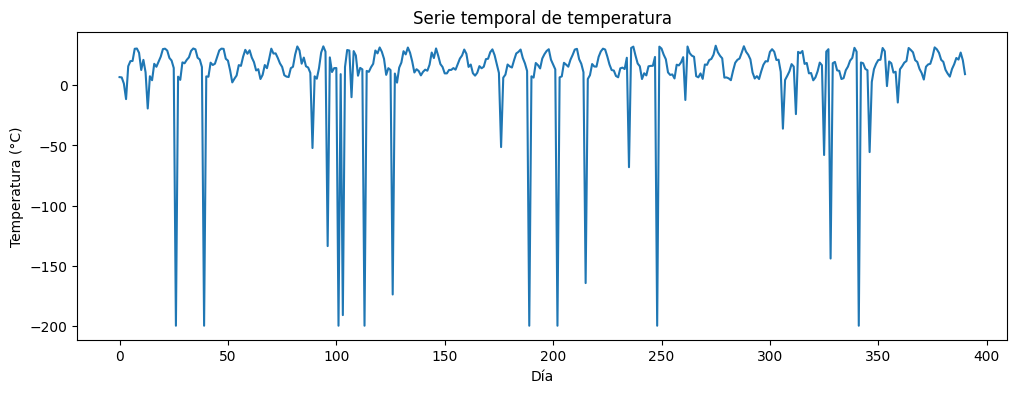

In [11]:
#Visualización de los datos
plt.figure(figsize=(12,4))
plt.plot(daily['T'])
plt.title("Serie temporal de temperatura")
plt.xlabel("Día")
plt.ylabel("Temperatura (°C)")
plt.show()

In [12]:
#Convertir a array
temps = daily['T'].values
print("Shape de la serie:", temps.shape)
print("Tipo de datos:", temps.dtype)
print("Máximo:", temps.max(), "Mínimo:", temps.min())
print("Media:", temps.mean(), "Desviación estándar:", temps.std())

Shape de la serie: (391,)
Tipo de datos: float64
Máximo: 32.99583333333333 Mínimo: -200.0
Media: 9.789518329070757 Desviación estándar: 38.45051903251776


## Normalizamos los datos para que todos esten en la misma escala de 0 y 1

In [13]:
def normalizarCaracteristicas(X):
    X_norm = X.copy()
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

#Normalizar características
X_scaled, mu_X, sigma_X = normalizarCaracteristicas(daily[features].values)
y_scaled, mu_y, sigma_y = normalizarCaracteristicas(daily[[target]].values)
y_scaled = y_scaled.flatten()

## Definimos las ventanas de iteracion para que el entrenamiento sea recursivo cada 7 dias:

In [15]:
window_size = 7   # días de entrada
horizon = 30      # días a predecir

X, y = [], []
for i in range(len(X_scaled) - window_size - horizon + 1):
    # Aplanar todos los features de los últimos 7 días
    X.append(X_scaled[i:i+window_size].flatten())
    y.append(y_scaled[i+window_size:i+window_size+horizon])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

## Dividimos los datos 80% entrenamiento 10% validacion 10% prueba:

In [17]:
#Train/Val/Test
split1 = int(0.8 * len(X))
split2 = int(0.9 * len(X))

X_train, X_val, X_test = X[:split1], X[split1:split2], X[split2:]
y_train, y_val, y_test = y[:split1], y[split1:split2], y[split2:]

## Funcion para el entrenamiento usando el log_each para evitar overtiting y el scheduler:

In [20]:
def fit(model, dataloader, optimizer, scheduler=None, epochs=10, log_each=1, early_stopping=0, verbose=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = torch.nn.MSELoss()  # para regresión usamos Mean Squared Error
    l, val_l, lr = [], [], []
    best_val_loss, step = float('inf'), 0

    for e in range(1, epochs+1):
        model.train()
        _l = []

        for x_b, y_b in dataloader['train']:
            x_b, y_b = x_b.to(device), y_b.to(device)
            optimizer.zero_grad()
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            loss.backward()
            optimizer.step()
            _l.append(loss.item())
        
        l.append(np.mean(_l))

        # Validación
        model.eval()
        _val_l = []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                x_b, y_b = x_b.to(device), y_b.to(device)
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _val_l.append(loss.item())
        
        val_loss_epoch = np.mean(_val_l)
        val_l.append(val_loss_epoch)

        # Guardar mejor modelo
        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            if verbose >= 2:
                print(f"Mejor modelo guardado con val_loss {best_val_loss:.5f} en epoch {e}")
        else:
            step += 1

        if scheduler:
            scheduler.step()

        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break

        if e % log_each == 0 and verbose:
            print(f"Epoch {e}/{epochs} train_loss {l[-1]:.5f} val_loss {val_l[-1]:.5f}")
    
    # Cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'val_loss': val_l}

In [21]:
#Dataset PyTorch
class TempDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [22]:

dataset = {
    'train': TempDataset(X_train, y_train),
    'val': TempDataset(X_val, y_val),
    'test': TempDataset(X_test, y_test)
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=32, shuffle=False),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, shuffle=False)
}

In [30]:
#Modelo
def build_model(D_in, H=128, D_out=30):
    return nn.Sequential(
        nn.Linear(D_in, H),
        nn.ReLU(),
        nn.Linear(H, H),
        nn.ReLU(),
        nn.Linear(H, D_out)
    ).cuda()

print("Número de batches para entrenar:", len(dataloader['train']))

Número de batches para entrenar: 18


## Entrenamiento:

In [31]:
D_in = X_train.shape[1]  # 7 días * 12 features = 84
model = build_model(D_in=D_in)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.1)
hist = fit(model, dataloader, optimizer, scheduler, epochs=100, early_stopping=10, verbose=2)

Mejor modelo guardado con val_loss 1.38455 en epoch 1
Epoch 1/100 train_loss 1.12271 val_loss 1.38455
Epoch 2/100 train_loss 1.04159 val_loss 1.40852
Epoch 3/100 train_loss 0.97964 val_loss 1.46495
Epoch 4/100 train_loss 0.90931 val_loss 1.53877
Epoch 5/100 train_loss 0.85161 val_loss 1.61229
Epoch 6/100 train_loss 0.81084 val_loss 1.64521
Epoch 7/100 train_loss 0.76483 val_loss 1.72811
Epoch 8/100 train_loss 0.72948 val_loss 1.74082
Epoch 9/100 train_loss 0.70022 val_loss 1.80180
Epoch 10/100 train_loss 0.66749 val_loss 1.81678
Epoch 11/100 train_loss 0.64026 val_loss 1.86416
Entrenamiento detenido en epoch 12 por no mejorar en 10 epochs seguidas


C:\Users\picas\AppData\Local\Temp\ipykernel_8572\1925193437.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpt.pt'))


El error observado es un error de seguridad, no es un error del modelo, nos avisa que solo debemos usar los pesos y no todo el checkpoint.

## Evaluamos y graficamos:

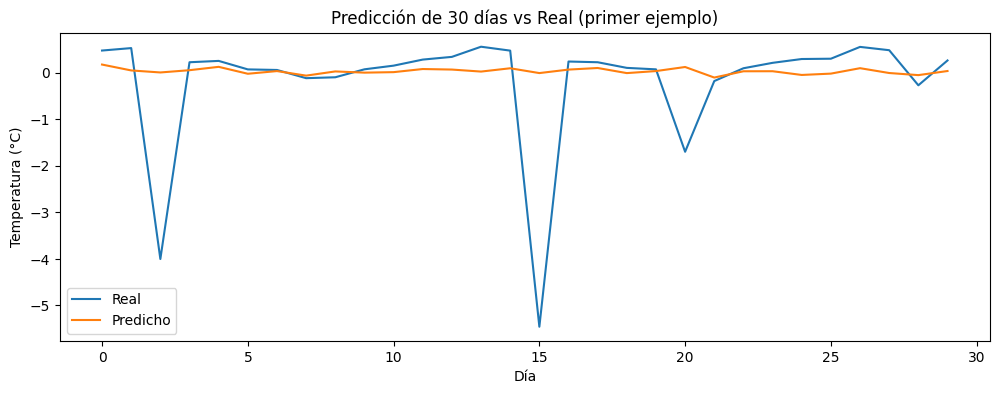

In [32]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy() 

y_true_30 = y_test[0]    # los 30 días reales
y_pred_30 = y_pred[0]    # los 30 días predichos


plt.figure(figsize=(12,4))
plt.plot(y_true_30, label='Real')
plt.plot(y_pred_30, label='Predicho')
plt.title("Predicción de 30 días vs Real (primer ejemplo)")
plt.xlabel("Día")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.show()
